### Описание проекта:

Сеть фитнес-центров «Культурист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста» перевёл в электронный вид множество анкет пользователей. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.   
А именно:   
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  
сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства; 
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:   
1) выделить целевые группы клиентов;  
2) предложить меры по снижению оттока;  
3) определить другие особенности взаимодействия с клиентами. 

### Знакомство с данными:

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from ipywidgets import interact

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
gym = pd.read_csv('/datasets/gym_churn.csv')
print(gym.describe())
print()
gym.info()
gym

            gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.00

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


Данные в отличном состоянии. Типы данных на месте, пропущенные значения отсутствуют.

### EDA

##### Средние значения групп

In [12]:
groups_mean = gym.groupby('Churn').mean()

feature = groups_mean.columns.values

def distplot(feature):
    sns.distplot(groups_mean[feature], bins = 5, legend = True)
    plt.title(feature)
    plt.show()
    
interact(distplot, feature = feature)

interactive(children=(Dropdown(description='feature', options=('gender', 'Near_Location', 'Partner', 'Promo_fr…

<function __main__.distplot(feature)>

In [5]:
feature = gym.drop('Churn', axis = 1).columns.values

def distplot2(feature):
    fig = px.histogram(gym, x = feature, marginal='box', color = 'Churn')
    fig.show()
    
interact(distplot2, feature = feature)

interactive(children=(Dropdown(description='feature', options=('gender', 'Near_Location', 'Partner', 'Promo_fr…

<function __main__.distplot2(feature)>

Пройдемся по признакам. В обеих группах мужчин и женщин почти поровну. Люди, живущие ближе к фитнес-центру, остаются с большей вероятностью (из тех, кто ушел 76% жило рядом, из тех, кто остался - 87%). Партнерская скидка также влияет в лучшую сторону. Также признак Promo_friends выше у первой группы почти вдвое - вместе веселее. У покинувших клиентов контрактный период также значительно ниже (5.7 месяцев против 1.7), что логично, так как они меньше теряют. Четко видна тенденция - все метрики у ушедших клиентов ниже, а некоторые значительно. Даже возраст ушедшей группы в среднем составляет 27 лет протв 30 из оставшихся клиентов. 

##### Матрица корреляций

In [6]:
gym.corr()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


Сильно корреллируют Month_to_end_contract и Contract_period, а также Avg_class_frequency_current_month и Avg_class_frequency_total

### Модель прогнозирования оттока пользователей

##### Разбиение выборки

In [7]:
X = gym.drop('Churn', axis = 1)
y = gym['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

##### Обучение модели

In [8]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)


X_test_st = scaler.transform(X_test)

forest_model = RandomForestClassifier(random_state = 0, n_estimators = 100)
forest_model.fit(X_train_st, y_train)
forest_predictions = forest_model.predict(X_test_st) 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, forest_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, forest_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, forest_predictions)))
print()

logistic_model = LogisticRegression(random_state=0)
logistic_model.fit(X_train_st, y_train)
logistic_predictions = logistic_model.predict(X_test_st) 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, logistic_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, logistic_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, logistic_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.81

Accuracy: 0.92
Precision: 0.85
Recall: 0.83


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Оба алгоритма показали хороший результат, однако логистическая модель оказалась на пару сотых долей лучше чем случайный лес

### Кластеризация пользователей

##### Дендрограмма

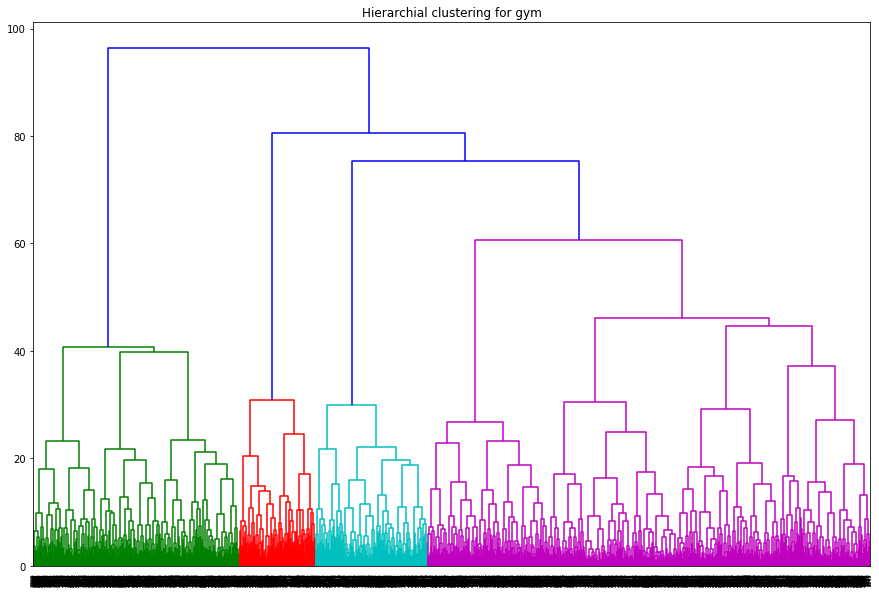

In [9]:
gym_st_x = scaler.transform(gym.drop('Churn', axis = 1)) 
km = KMeans(n_clusters = 5, random_state = 0)            
labels = km.fit_predict(gym_st_x)
gym['cluster_km'] = labels
linked = linkage(X_train_st, method = 'ward') 
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for gym')
plt.show()

##### Распределение признаков по кластерам

In [10]:
cluster_grpd = gym.groupby('cluster_km').mean()
feature = cluster_grpd.drop('Churn', axis = 1).columns

def distplot3(feature):
    fig = px.histogram(gym, x = feature, y = feature, marginal='box', color = 'cluster_km')
    fig.show()
    
interact(distplot3, feature = feature)

interactive(children=(Dropdown(description='feature', options=('gender', 'Near_Location', 'Partner', 'Promo_fr…

<function __main__.distplot3(feature)>

##### Доля оттока

,count,share
cluster_km,,
1,386,0.27
4,632,0.25
0,868,0.02
3,885,0.09
2,1229,0.57


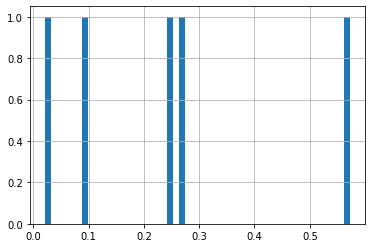

In [11]:
cluster_grpd['Churn'].hist(bins = 50)
cluster_frame = pd.DataFrame({'count': gym.groupby('cluster_km')['cluster_km'].count(), 'share': cluster_grpd['Churn'].round(2)})
cluster_frame.sort_values('count')

(Так как калстерам всегда даются разные номера выше таблица соответствия доли оттока к количеству клиентов в кластере) Кластер с наименьшим оттоком (2%) насчитывает в себе 868 клиентов и является самым привлекательным кластером среди остальных. Следом идет похожий с 9 процентами отока и 885 людьми. Судя по графикам эти кластеры так же находятся впереди по таким признакам как Lifetime, Avg_additional_purchases, Avg_class_frequency_total, Avg_class_frequency_curren_month и Group_visits.  
Кластер с самым большим оттоком - 57% оказался также и самым большим по количеству. 

### Выводы

Кластеры с оттоками 2% и 9% - самые важные для бизнеса и лидируют по всем важным признакам. Клиенты данных групп практически не уходят, принося наибольшее количество денег в перспективе. Удержать и так довольных клиентов проще чем искать новых или переубеждать кластер с оттоком в 57%. Например группа с оттоком в 2% потчти полностью состоит из людей с абонементами на 12 месяцев. Таких долгожителей можно поощрять, а под конец срока предложить специальные условия приобретения нового абонимента.  
Можно попробовать поработать над самым плачевным кластером, так как он является одновременно и самым большим. Клиенты этой категории в основном берут абонемент на месяц и сразу же после уходят. Возможно нужно предоставить им персонального тренера на большее количество занятий. Может они делают что-то неправильно или чего-то не понимают, а тренер придаст им мотивации и покажет, как правильно выполнять упражнения. Таким образом можно сократить количество людей в этом кластере. Благо их телефоны у нас имеются.